In [1]:
import os, sys, time
sys.path.append('./')

import numpy as np
import pandas as pd
import pickle, csv
from scipy.interpolate import interp1d

from astropy import wcs
from astropy.io import fits

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

import main as m
from main import spectraAna

### STEP 1. Open FITS image cube

In [26]:
## Open FITS image cube
fitscubename = '../data/cold_spw2.fits'
s = spectraAna(fitscubename = fitscubename)
s.readfits(verbose = False)

naxis1   = s.naxis1
naxis2   = s.naxis2
ctype3   = s.ctype3
naxis3   = s.naxis3
crpix3   = s.crpix3
cdelt3   = s.cdelt3
crval3   = s.crval3 
restfreq = s.restfreq
cube     = s.cube  ## all intensity 
freq_array = s.freq_array
velo_array = s.velo_array

### STEP 2.  Convert the data format using `gausspy`.

In [38]:
rms_spw0 = 0.0018148618
rms_spw1 = 0.0017738817
rms_spw2 = 0.0025416217
rms_spw3 = 0.0018573649

# FITS -> Gausspy set
s.Gtransdata( cube = cube, velo=velo_array, freq=freq_array,
              spw_id = '2', rms = rms_spw2, base = 'velo',
              xrange1 = 0, xrange2 = naxis1,
              yrange1 = 0, yrange2 = naxis2  )

### STEP 3. Unredshift spectra

In [60]:
data = pickle.load(open('cube_2.pickle','rb'))
molecule = 'sio'

if molecule == 'sio':
    shift_info = pickle.load(open('shift_info_sio.pickle', 'rb'))
elif molecule == 'so':
    shift_info = pickle.load(open('shift_info_so.pickle', 'rb'))

    
intensity_list = []
shifted_x_list = []

if len(data['data_list']) != len(shift_info['delta_value']):
    raise ValueError("Mismatch in length between data and shift_info dictionaries.")
    
else:
    shifted_x_list = [velo_array - dv for dv in shift_info['delta_value'] if len(dv) != 0]
    intensity_list = [data['data_list'][i] for i, dv in enumerate(shift_info['delta_value']) if len(dv) != 0]

### STEP 4. Stack spectra

In [ ]:
# create the new x_value array to cover all freq(or velo) value
minx = min(min(x) for x in shifted_x_list)
maxx = max(max(x) for x in shifted_x_list)
mean_spacing = np.mean([np.mean(np.diff(x)) for x in shifted_x_list])
points = int( (maxx - minx)/ mean_spacing)
newx_array = np.linspace(minx, maxx, -points)


# stack the spectra
average_inten_shift = s.stack_spectra(newx_array, 
                                      shifted_x_list, 
                                      intensity_list,
                                      option='unredshift')

average_inten_noshift = s.stack_spectra(newx_array, 
                                      shifted_x_list, 
                                      intensity_list, 
                                      option='redshift')

# plot the result
m.plot_spectra(newx_array/1e3, average_inten_shift, 
               figsize=(10,6), color='black',
               xlabel='Velocity[km/s]',
               xlabel_size = 30, ylabel_size = 30, 
               xtick_size  = 30, ytick_size  = 30
              )

m.plot_spectra(velo_array/1e3, average_inten_noshift, 
               figsize=(10,6), color='black',
               xlabel='Velocity[km/s]',
               xlabel_size = 30, ylabel_size = 30, 
               xtick_size  = 30, ytick_size  = 30
              )

Generate the figure using the **SiO** velocity distribution.

In [19]:
# search the velocities of N2D+
freq = [ 231.3199064e9, 231.319957e9, 231.3199797e9, 231.3212109e9, 231.321416e9, 231.3214595e9,
           231.3214836e9, 231.3215039e9, 231.3215801e9
       ]
for f in freq:
    v = c * (1 - f / restfreq)
    print(v/1e3)

-545.1917357554448
-545.2574330199557
-545.2869059034488
-546.8854527821107
-547.1517474254354
-547.2082262990263
-547.2395168933864
-547.2658737010887
-547.3648091073455


428 455
1084 1111


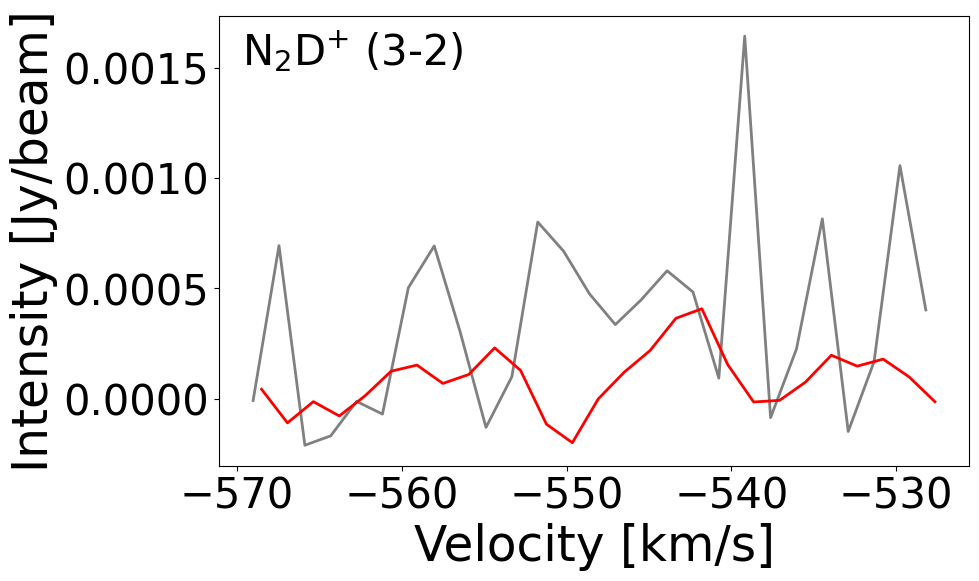

In [68]:
## View specific range (velocity in km/s, frequency in GHz)
x_start = -570
x_end   = -527

x_startpix = np.searchsorted(newx_array, x_start*1e3) 
x_endpix   = np.searchsorted(newx_array, x_end*1e3)

x_start_no = np.searchsorted(-velo_array, -x_end*1e3) #due to the descending array
x_end_no   = np.searchsorted(-velo_array, -x_start*1e3)

print(x_startpix, x_endpix)
print(x_start_no, x_end_no)

# Plot
sliced_x    = newx_array[x_startpix:x_endpix]
sliced_x_no = velo_array[x_start_no:x_end_no]
sliced_inten = average_inten_shift[x_startpix:x_endpix]
sliced_inten_noshift = average_inten_noshift[x_start_no:x_end_no]

fig = plt.figure(figsize = (10,6))
ax = fig.add_axes([0.12, 0.1, 0.75, 0.75])
#ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False)

ax.tick_params(axis='both', labelsize=30)

plt.xlabel('Velocity [km/s]', size = 35)
plt.ylabel('Intensity [Jy/beam]', size = 35)

plt.plot(sliced_x_no/1e3, sliced_inten_noshift, '-', color='grey', linewidth = 2.0)
plt.plot(sliced_x/1e3, sliced_inten,'-', color='red', linewidth = 2.0)

plt.text(0.03, 0.87, 'N$_{2}$D$^{+}$ (3-2)', 
         verticalalignment = 'bottom', horizontalalignment = 'left',
         color='black', transform = ax.transAxes, fontsize=30)

#plt.savefig('Stackn2d+_wsio.png',bbox_inches='tight')

Generate the figure using the **SO** velocity distribution.

1143 1168
1087 1112


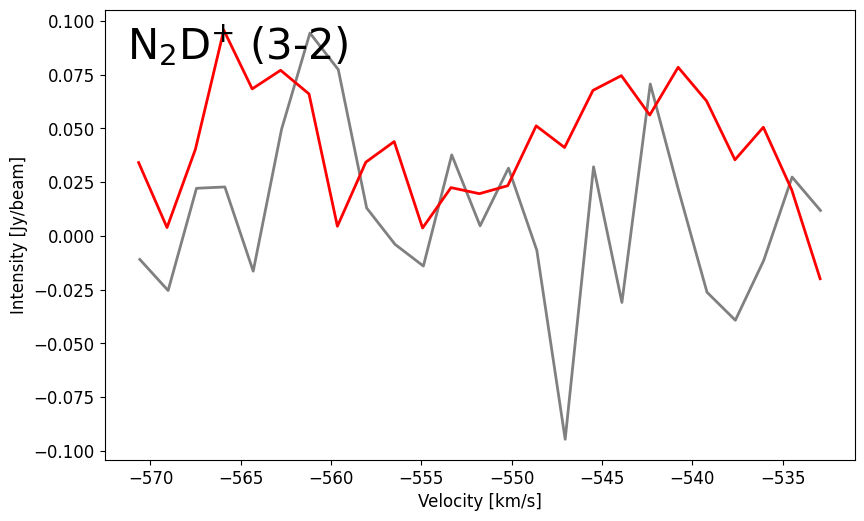

In [39]:
## View specific range (velocity in km/s, frequency in GHz)
x_start = -570
x_end   = -527

x_startpix = np.searchsorted(newx_array, x_start*1e3) 
x_endpix   = np.searchsorted(newx_array, x_end*1e3)

x_start_no = np.searchsorted(-velo_array, -x_end*1e3) #due to the descending array
x_end_no   = np.searchsorted(-velo_array, -x_start*1e3)

print(x_startpix, x_endpix)
print(x_start_no, x_end_no)

# Plot
sliced_x    = newx_array[x_startpix:x_endpix]
sliced_x_no = velo_array[x_start_no:x_end_no]
sliced_inten = average_inten_shift[x_startpix:x_endpix]
sliced_inten_noshift = average_inten_noshift[x_start_no:x_end_no]

fig = plt.figure(figsize = (10,6))
ax = fig.add_axes([0.12, 0.1, 0.75, 0.75])
#ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False)

ax.tick_params(axis='both', labelsize=30)

plt.xlabel('Velocity [km/s]', size = 35)
plt.ylabel('Intensity [Jy/beam]', size = 35)

plt.plot(sliced_x_no/1e3, sliced_inten_noshift, '-', color='grey', linewidth = 2.0)
plt.plot(sliced_x/1e3, sliced_inten,'-', color='red', linewidth = 2.0)

plt.text(0.03, 0.87, 'N$_{2}$D$^{+}$ (3-2)', 
         verticalalignment = 'bottom', horizontalalignment = 'left',
         color='black', transform = ax.transAxes, fontsize=30)

#plt.savefig('Stackn2d+_wso.png',bbox_inches='tight')